#Import libraries


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.image import resize
import tensorflow.keras as K
import cv2
import seaborn as sns
from tensorflow.keras.applications import DenseNet121




#Data preprocess(Load, normalize and augmnet the data)

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)


x_train.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


(50000, 32, 32, 3)

#Resize the data

In [3]:
# Set batch size
batch_size = 64

def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))  # Resize for consistency
    return img, label

train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation and resizing
    .batch(batch_size)  # Batch data
    .prefetch(tf.data.AUTOTUNE)  # Prefetch for better performance
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)  # Only resize
    .batch(batch_size)  # Batch data
    .prefetch(tf.data.AUTOTUNE)  # Prefetch for better performance
)

#Data aumentation


In [4]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

#Use MobileNestV2 pre-trained model

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

#Freez the pretrained model

In [6]:
base_model.trainable = False  # Freeze the base model

for layer in base_model.layers[-50:]:
    layer.trainable = True

#Design the model architecture

In [7]:
inputs = layers.Input(shape=(224, 224, 3))
x = augmentation(inputs)
x = layers.Resizing(224, 224)(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs, outputs)

#optimize and complie the model

In [8]:
optimizer = K.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Initialize early_stopping and lr_scheduler method

In [9]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.01,
    restore_best_weights=True
)

#Train the data

In [10]:
history_1 = model.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 73ms/step - accuracy: 0.7704 - loss: 0.7060 - val_accuracy: 0.4999 - val_loss: 3.5907 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.8913 - loss: 0.3326 - val_accuracy: 0.3712 - val_loss: 5.7170 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9179 - loss: 0.2481 - val_accuracy: 0.4041 - val_loss: 5.3878 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9341 - loss: 0.1991 - val_accuracy: 0.6765 - val_loss: 1.8403 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9482 - loss: 0.1556 - val_accuracy: 0.4850 - val_loss: 5.1411 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9538 - loss: 0.1394 - val_accuracy: 0.6048 - val_loss: 3.2346 - learning_rate: 0.0010
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9

In [11]:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step


#Evaluate the model

Accuracy: 0.924
test_loss: 0.7100747227668762
Precision: 0.9248088164142793
Recall: 0.924
F1 Score: 0.9240565010258319


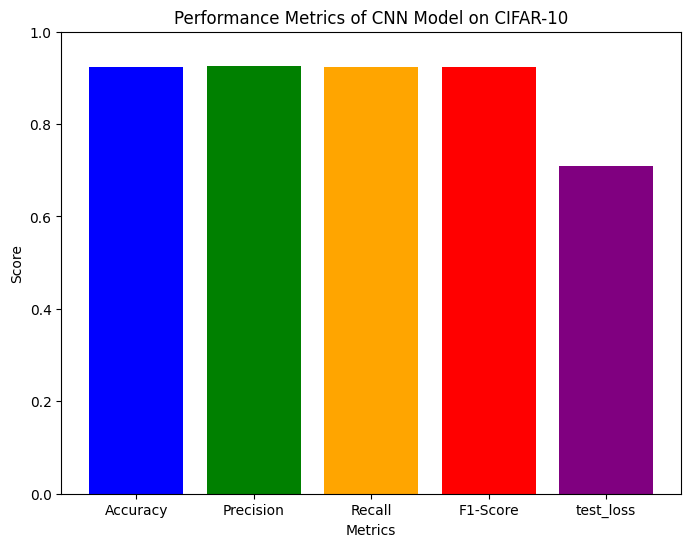

In [12]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
test_loss = history_1.history['val_loss'][-1]

print("Accuracy:",accuracy)
print("test_loss:",test_loss)
print("Precision:",precision)
print("Recall:",recall)
print("F1 Score:",f1)


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score','test_loss']
values = [accuracy, precision, recall, f1,test_loss]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Performance Metrics of CNN Model on CIFAR-10')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()

#Show model_1 confusion matrix

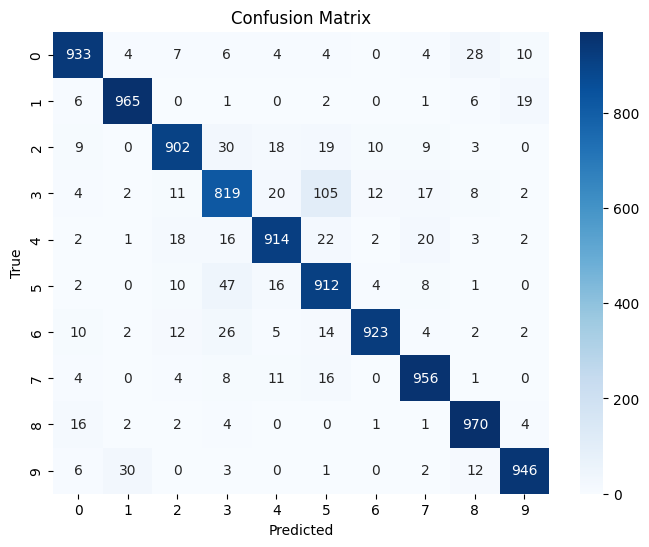

In [13]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#Compare the two transfer models

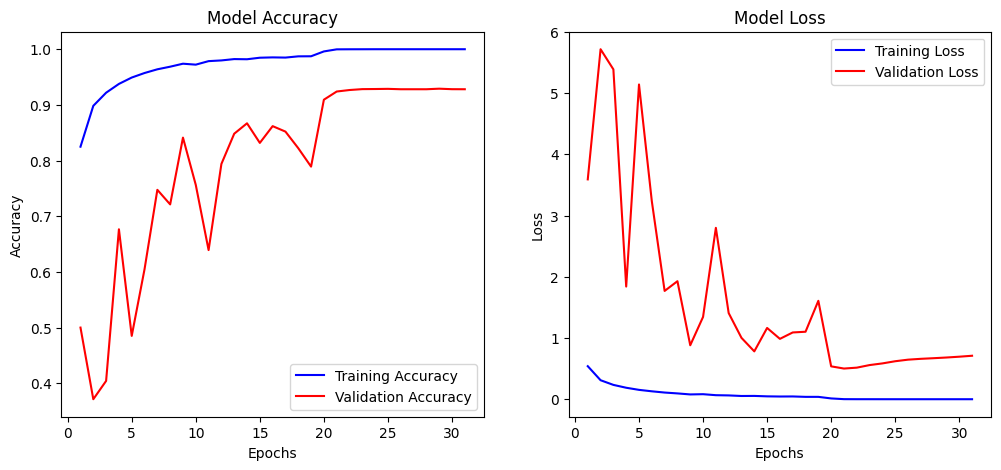

In [20]:
import matplotlib.pyplot as plt

# Example training history from a Keras model
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Accuracy vs. Epochs
    axs[0].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
    axs[0].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot Loss vs. Epochs
    axs[1].plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    axs[1].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    # Show the plots
    plt.show()

plot_training_history(history_1)


#Predict random image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


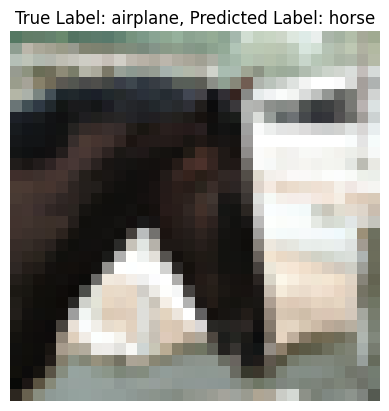

Prediction probabilities for each class:
[2.61595433e-13 1.70432700e-12 2.63724589e-13 5.01416140e-12
 1.72270097e-12 1.43104355e-08 2.55746856e-12 1.00000000e+00
 3.45449894e-15 2.85483824e-11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


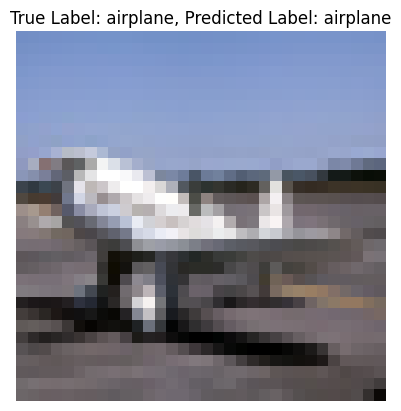

Prediction probabilities for each class:
[9.9999988e-01 7.8187732e-08 4.4659453e-11 1.5895976e-13 5.0090823e-13
 1.7411791e-13 1.2255453e-12 1.7359770e-12 1.5226194e-09 2.5756947e-11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


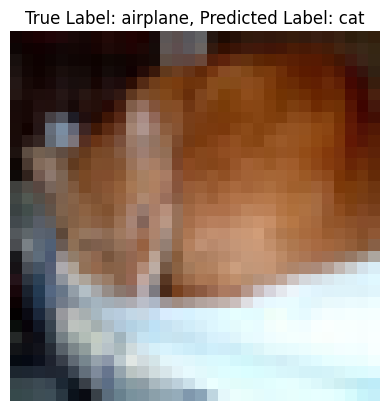

Prediction probabilities for each class:
[1.9359871e-11 4.5030993e-11 4.6057527e-09 9.9998987e-01 1.9649329e-08
 1.0112587e-05 2.0939595e-08 3.8270728e-10 8.0737396e-11 6.0245806e-12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


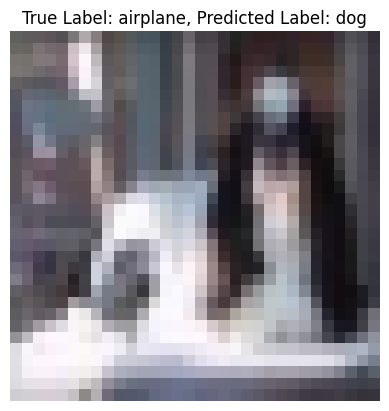

Prediction probabilities for each class:
[3.3737930e-15 7.1506855e-16 3.2110986e-10 1.4031121e-09 4.7085985e-12
 9.9999988e-01 1.1667193e-11 9.4334361e-08 2.1118873e-14 1.0477646e-12]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


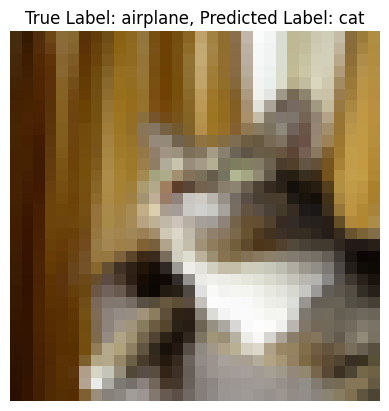

Prediction probabilities for each class:
[1.5383283e-19 1.1275720e-17 4.0617021e-18 1.0000000e+00 1.6807712e-15
 1.0838778e-08 6.8071633e-13 1.1998048e-16 2.6497766e-16 1.4529024e-20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


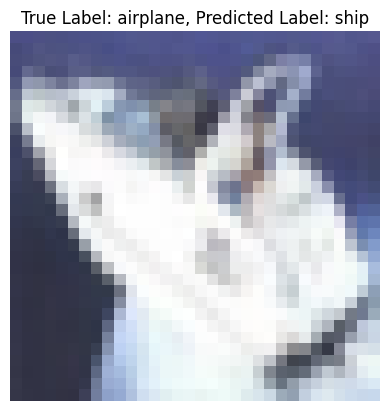

Prediction probabilities for each class:
[1.18894246e-08 1.05230447e-08 3.29853066e-07 1.91676364e-07
 1.70150261e-09 8.82883811e-08 3.83595943e-06 1.02423037e-09
 9.99995470e-01 1.05798375e-08]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


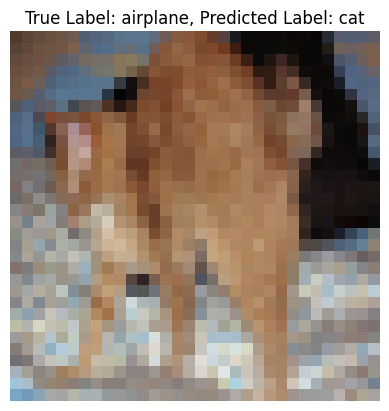

Prediction probabilities for each class:
[5.52300898e-16 8.94640914e-18 1.08623024e-13 1.00000000e+00
 4.80628731e-12 3.21992884e-11 3.48006454e-12 3.17228874e-15
 3.69150061e-17 2.41035716e-17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


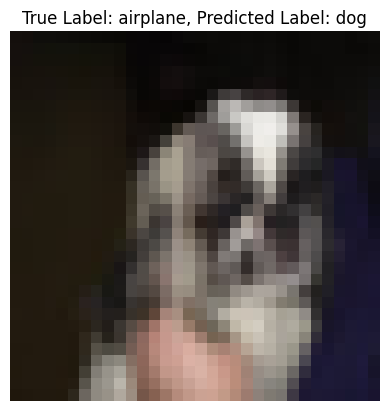

Prediction probabilities for each class:
[1.0927958e-19 3.5586025e-21 1.2913415e-12 1.6333414e-14 3.5762863e-14
 1.0000000e+00 3.3781433e-13 1.5932107e-12 9.3997393e-20 1.1978567e-16]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


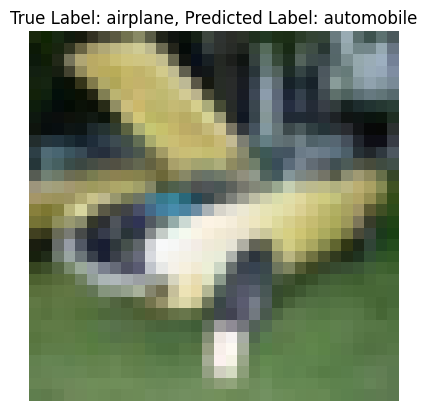

Prediction probabilities for each class:
[9.21337395e-10 1.00000000e+00 2.55561513e-16 1.47889750e-14
 1.00170454e-19 9.33152058e-16 1.20908315e-13 1.57680689e-16
 1.16233766e-10 1.38175901e-10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


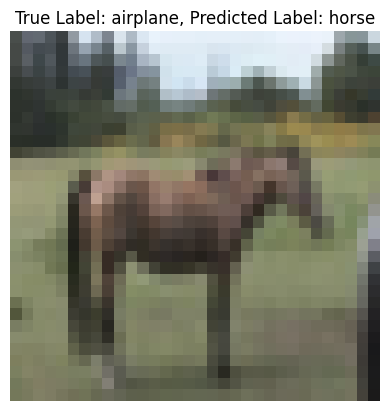

Prediction probabilities for each class:
[1.9772516e-18 6.6463803e-17 1.4802491e-18 9.2855877e-20 3.1860502e-17
 1.0597799e-12 4.3169399e-16 1.0000000e+00 1.6851061e-21 1.5265407e-15]


In [48]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Select the last 10 test images
num_images = 10
indices = list(range(len(x_test) - num_images, len(x_test)))  # Get indices for the last 10 images

for idx in indices:
    image = x_test[idx]  # Select image
    true_label = np.argmax(y_test[idx])  # Convert one-hot encoding to class index

    # Resize image to match model input
    image_resized = tf.image.resize(image, (224, 224)).numpy().reshape(1, 224, 224, 3)

    # Predict label
    prediction = model.predict(image_resized)
    predicted_label = np.argmax(prediction)

    # Display the image (original for visualization)
    plt.imshow(image)
    plt.title(f'True Label: {class_names[true_label]}, Predicted Label: {class_names[predicted_label]}')
    plt.axis('off')
    plt.show()

    # Print prediction probabilities
    print(f"Prediction probabilities for each class:\n{prediction[0]}")


#save model

In [50]:
model.save('model.keras')